In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
! pip install keras_utils

  Created wheel for keras-utils: filename=keras_utils-1.0.13-cp36-none-any.whl size=2657 sha256=0fe822ce2ac87a061e2fb6adf25486b41301cec19fbc48dee2f97a06098cb2d7
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras-utils


In [ ]:
import keras_utils
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [ ]:

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

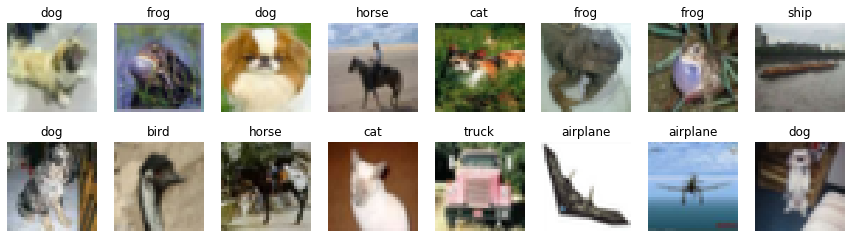

In [ ]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [ ]:
x_train2 = x_train/255 - 0.5 
x_test2 = x_test/255 - 0.5 

y_train2 = keras.utils.to_categorical(y_train, num_classes=10) 
y_test2 = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
def make_model():
  
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

In [ ]:
model = make_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         


In [ ]:
model.compile(
    loss='categorical_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=0.01),  
    metrics=['accuracy']  
)

def lr_scheduler(epoch):
    return 0.01 * 0.9 ** epoch

class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [ ]:
model.fit(
    x_train2, y_train2,  
    batch_size=32,
    epochs=10,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory()],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=0
)

Learning rate: 0.01
Learning rate: 0.009
Learning rate: 0.0081
Learning rate: 0.00729
Learning rate: 0.006561
Learning rate: 0.0059049
Learning rate: 0.00531441
Learning rate: 0.004782969
Learning rate: 0.004304672
Learning rate: 0.0038742048


In [ ]:

y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

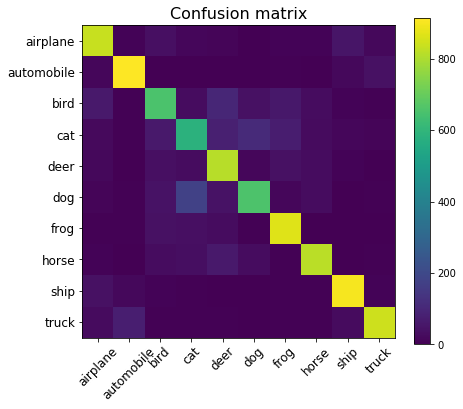

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()


In [ ]:
 def image_values_to_rgb(x):

        # so that it looks like a normalized image input for our network
        x = (x - np.mean(x)) / np.std(x) * 0.25 

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x + 0.5) * 255 ### YOUR CODE HERE
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

In [ ]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
  

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [ ]:
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

leaky_re_lu_1


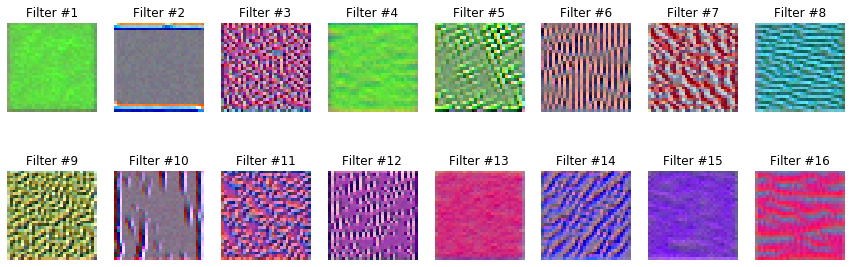

leaky_re_lu_2


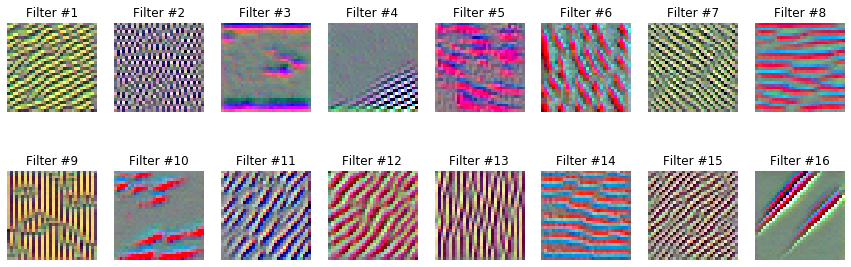

leaky_re_lu_3


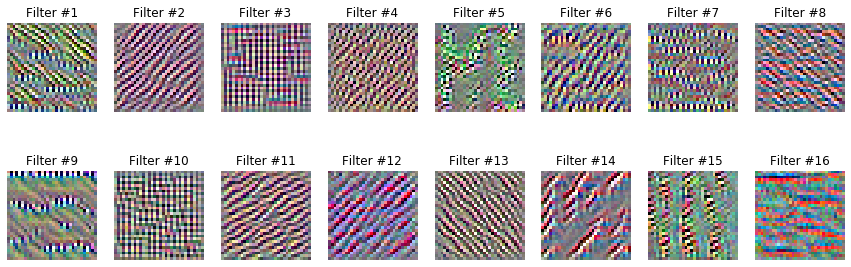

leaky_re_lu_4


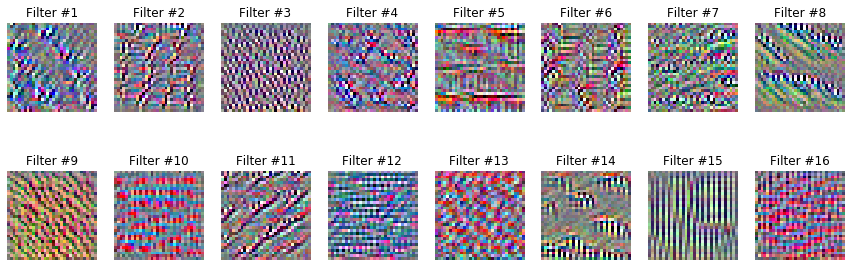

In [ ]:
prev_layer = None
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    if isinstance(layer, LeakyReLU):
        # prev_layer = layer.inbound_nodes[0].inbound_layers[0]
        if isinstance(prev_layer, Conv2D):
            conv_activation_layers.append(layer)
    prev_layer = layer

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

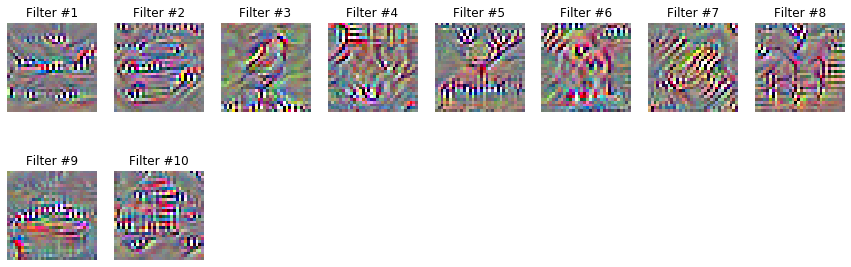

In [ ]:
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)